In [25]:
# Get PGD from the displacement outputs from SW4 for both the FQ run and the UGSS run
# Calculate the moment and Mw for the FQ ruptures to verify that they're okay

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from obspy.core import read, Stream
import pandas as pd
from obspy.geodetics import gps2dist_azimuth, kilometer2degrees

In [32]:
# Event
event_file = 'M6_catalog_2004-2024.csv'
eventLocs = pd.read_csv('/Users/sydneydybing/SW4/strain/' + event_file, dtype = 'str')

# Ridgecrest
event = eventLocs.iloc[11]
eq_lat = float(event.latitude)
eq_lon = float(event.longitude)

In [33]:
# Stations

sta_file = 'bsm_metadata.csv'
stas = pd.read_csv('/Users/sydneydybing/SW4/strain/' + sta_file)
rc_stas_sub = ['B072', 'B079', 'B082', 'B087', 'B916', 'B917', 'B918', 'B921'] # subset of stations close to Ridgecrest - 4 super close, 2 west, 2 south
stas_sub = stas.query('BNUM in @rc_stas_sub').reset_index(drop = True)
stas_sub

,BNUM,NAME,LAT,LONG,ELEV(m),INSTALL_DATE,CH0(EofN),BSM_Depth(m),SEISMOMETER_Depth(m),PORE_DEPTH(m),DATA_START,->,DATA_END,GAP(m),L_DATE,L0(cnts),L1(cnts),L2(cnts),L3(cnts),REGION
0,B072,goldhl072bcn2007,35.83100,-120.34500,397.7,8/27/07,219.7,159.7,154.5,NaN,2007:239,->,Present,0.0001,2007:253,47592395,52739856,51898099,51846814,Parkfield_California
1,B079,jackcn079bcs2006,35.71570,-120.20570,436.6,10/13/06,353.7,181.5,175.1,45.00,2006:286,->,Present,0.0001,2006:318,48042444,48981765,47787315,49995315,Parkfield_California
2,B082,pathfi082bcs2006,33.59818,-116.59600,1374.8,6/10/06,324.8,242.6,220.7,22.60,2006:162,->,Present,0.0002,2006:335,49597819,53081549,47839224,49741765,Anza_California
3,B087,fordra087bcs2006,33.49550,-116.60267,1139.0,6/17/06,340.7,160.9,147.5,24.38,2006:194,->,Present,0.0002,2006:335,49940592,51287823,50044783,49977525,Anza_California
4,B916,marips916bcs2008,36.19250,-117.66850,1859.9,3/13/08,303.6,176.5,166.9,NaN,2008:073,->,Present,0.0001,2008:090,55948375,53191200,55522127,49391430,Mojave_California
5,B917,tonyso917bcs2008,35.38920,-117.25870,1125.9,7/14/08,306.1,162.5,Unknown,NaN,2008:196,->,Present,0.0001,2008:219,51200216,53318503,50164819,49964400,Mojave_California
6,B918,mtsprn918bcs2008,35.93570,-117.60170,1042.6,6/21/08,288.9,196.7,189.9,NaN,2008:173,->,Present,0.0001,2008:245,56324863,55262353,53608304,55388642,Mojave_California
7,B921,randsb921bcs2008,35.58650,-117.46220,694.5,6/3/08,340.5,147.4,139.9,NaN,2008:157,->,Present,0.0001,2008:178,53324139,53302937,55141972,53475662,Mojave_California


In [34]:
usgs_path = '/Users/sydneydybing/SW4/strain/usgs_rc-results/'
fq_path = '/Users/sydneydybing/SW4/strain/fq300-results/'

In [70]:
usgs_pgd_mags = []
fq_pgd_mags = []
usgs_ps_mags = []
fq_ps_mags = []
real_ps_mags = []
hypdists = []

for i in range(len(stas_sub.BNUM.values)):
    sta = stas_sub.BNUM.values[i]
    sta_lat = stas_sub.LAT.values[i]
    sta_lon = stas_sub.LONG.values[i]
    
    print('------- ' + str(sta) + ' -------')
    print('')
    
    # Calculate hypocentral distance
    distaz = gps2dist_azimuth(eq_lat, eq_lon, sta_lat, sta_lon)
    dist_m = distaz[0]
    dist_km = dist_m/1000
    print('Hypocentral distance (km): ' + str(round(dist_km,1)))
    hypdists.append(dist_km)
    
    # Load displacement data
    disp_usgs = pd.read_csv(usgs_path + sta + 'd.txt', sep = '\s+', skiprows = 16, names = ['time', 'x', 'y', 'z'])
    disp_fq = pd.read_csv(fq_path + sta + 'd.txt', sep = '\s+', skiprows = 16, names = ['time', 'x', 'y', 'z'])
    
    # Calculate PGDs
    x_usgs = disp_usgs.x.values
    y_usgs = disp_usgs.y.values
    z_usgs = disp_usgs.z.values

    pgd_usgs = max(np.sqrt(x_usgs**2 + y_usgs**2 + z_usgs**2))

    x_fq = disp_fq.x.values
    y_fq = disp_fq.y.values
    z_fq = disp_fq.z.values

    pgd_fq = max(np.sqrt(x_fq**2 + y_fq**2 + z_fq**2))
    
    print('SW4 USGS PGD (m): ' + str(round(pgd_usgs,5)))
    print('SW4 FQ PGD (m): ' + str(round(pgd_fq,5)))
    
    # Calculate Mw from PGD scaling law (Crowell et al., 2013; Melgar et al., 2015)
    print('')
    print('PGD scaling law Mw:')
    A = -4.434
    B = 1.047
    C = -0.138
    
    Mw_usgs_pgd = (np.log10(pgd_usgs) - A) / (B + C * np.log10(dist_km))
    Mw_fq_pgd = (np.log10(pgd_fq) - A) / (B + C * np.log10(dist_km))
    
    print('SW4 USGS Mw (target 7.0): ' + str(round(Mw_usgs_pgd,2)))
    print('SW4 FQ Mw (target 7.0): ' + str(round(Mw_fq_pgd,2)))
    
    usgs_pgd_mags.append(Mw_usgs_pgd)
    fq_pgd_mags.append(Mw_fq_pgd)
    
    # Load strain data
    strain_usgs = pd.read_csv(usgs_path + sta + '.txt', sep = '\s+', skiprows = 16, names = ['time', 'xx', 'yy', 'zz', 'xy', 'xz', 'yz'])
    strain_fq = pd.read_csv(fq_path + sta + '.txt', sep = '\s+', skiprows = 16, names = ['time', 'xx', 'yy', 'zz', 'xy', 'xz', 'yz'])
    
    # Calculate peak RMS strain
    xx_usgs = strain_usgs.xx.values
    xy_usgs = strain_usgs.xy.values
    yy_usgs = strain_usgs.yy.values

    peak_rms_usgs = max(np.sqrt((xx_usgs**2 + xy_usgs**2 + yy_usgs**2)/3))

    xx_fq = strain_fq.xx.values
    xy_fq = strain_fq.xy.values
    yy_fq = strain_fq.yy.values

    peak_rms_fq = max(np.sqrt((xx_fq**2 + xy_fq**2 + yy_fq**2)/3))
    
    # Add in real Ridgecrest strain data for these stations to further compare
    real_path = '/Users/sydneydybing/StrainProject/2024/strain_data/rms/2019-07-06_M7.1/'
    
    # Calculate Mw from peak RMS strain scaling law (Barbour and Crowell, 2017)
    print('')
    print('Peak strain scaling law Mw:')
    
    try:
        real_rms = read(real_path + sta + '.mseed')
        peak_rms_real = max(real_rms[0].data)
        Mw_real_ps = (np.log10(peak_rms_real) + 7.899 + 2.599 * np.log10(dist_km)) / 1.234
        
        print('Real RMS strain Mw (target 7.1): ' + str(round(Mw_real_ps,2)))
        
        real_ps_mags.append(Mw_real_ps)

    except:
        print('No real RMS strain data available for station ' + str(sta))
        real_ps_mags.append(np.nan)
    
    Mw_usgs_ps = (np.log10(peak_rms_usgs) + 7.899 + 2.599 * np.log10(dist_km)) / 1.234
    Mw_fq_ps = (np.log10(peak_rms_fq) + 7.899 + 2.599 * np.log10(dist_km)) / 1.234
    
    print('SW4 USGS Mw (target 7.0): ' + str(round(Mw_usgs_ps,2)))
    print('SW4 FQ Mw (target 7.0): ' + str(round(Mw_fq_ps,2)))
    
    usgs_ps_mags.append(Mw_usgs_ps)
    fq_ps_mags.append(Mw_fq_ps)
    
    print('')
    print('')
    print('')

------- B072 -------

Hypocentral distance (km): 248.3
SW4 USGS PGD (m): 0.00492
SW4 FQ PGD (m): 0.00595

PGD scaling law Mw:
SW4 USGS Mw (target 7.0): 2.97
SW4 FQ Mw (target 7.0): 3.08

Peak strain scaling law Mw:
Real RMS strain Mw (target 7.1): 6.78
SW4 USGS Mw (target 7.0): 6.49
SW4 FQ Mw (target 7.0): 6.61



------- B079 -------

Hypocentral distance (km): 235.8
SW4 USGS PGD (m): 0.0055
SW4 FQ PGD (m): 0.00686

PGD scaling law Mw:
SW4 USGS Mw (target 7.0): 3.02
SW4 FQ Mw (target 7.0): 3.16

Peak strain scaling law Mw:
Real RMS strain Mw (target 7.1): 6.68
SW4 USGS Mw (target 7.0): 6.6
SW4 FQ Mw (target 7.0): 6.62



------- B082 -------

Hypocentral distance (km): 257.8
SW4 USGS PGD (m): 0.01213
SW4 FQ PGD (m): 0.00542

PGD scaling law Mw:
SW4 USGS Mw (target 7.0): 3.53
SW4 FQ Mw (target 7.0): 3.03

Peak strain scaling law Mw:
Real RMS strain Mw (target 7.1): 5.56
SW4 USGS Mw (target 7.0): 6.81
SW4 FQ Mw (target 7.0): 6.54



------- B087 -------

Hypocentral distance (km): 268.3

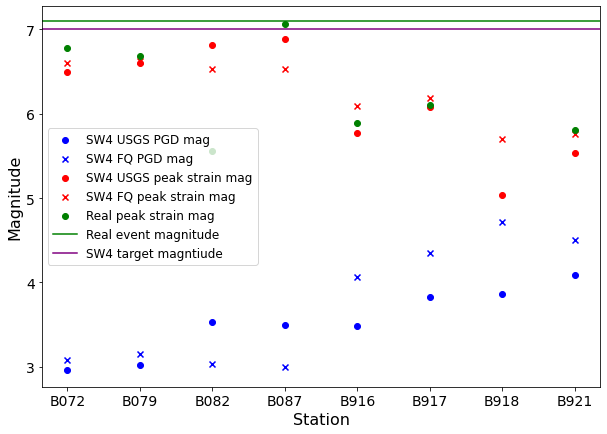

In [85]:
plt.figure(figsize = (10,7))
plt.scatter(rc_stas_sub, usgs_pgd_mags, color = 'blue', label = 'SW4 USGS PGD mag')
plt.scatter(rc_stas_sub, fq_pgd_mags, marker = 'x', color = 'blue', label = 'SW4 FQ PGD mag')
plt.scatter(rc_stas_sub, usgs_ps_mags, color = 'red', label = 'SW4 USGS peak strain mag')
plt.scatter(rc_stas_sub, fq_ps_mags, marker = 'x', color = 'red', label = 'SW4 FQ peak strain mag')
plt.scatter(rc_stas_sub, real_ps_mags, color = 'green', label = 'Real peak strain mag')
plt.axhline(7.1, color = 'green', label = 'Real event magnitude')
plt.axhline(7.0, color = 'purple', label = 'SW4 target magntiude')
plt.ylabel('Magnitude', fontsize = 16)
plt.xlabel('Station', fontsize = 16)
plt.tick_params(labelsize = 14)
plt.legend(loc = 'center left', fontsize = 12);


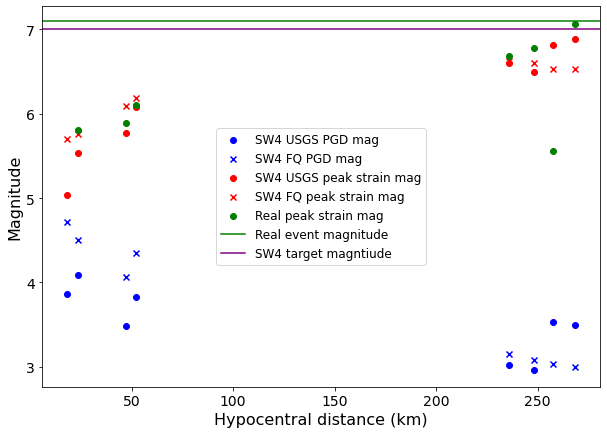

In [88]:
plt.figure(figsize = (10,7))
plt.scatter(hypdists, usgs_pgd_mags, color = 'blue', label = 'SW4 USGS PGD mag')
plt.scatter(hypdists, fq_pgd_mags, marker = 'x', color = 'blue', label = 'SW4 FQ PGD mag')
plt.scatter(hypdists, usgs_ps_mags, color = 'red', label = 'SW4 USGS peak strain mag')
plt.scatter(hypdists, fq_ps_mags, marker = 'x', color = 'red', label = 'SW4 FQ peak strain mag')
plt.scatter(hypdists, real_ps_mags, color = 'green', label = 'Real peak strain mag')
plt.axhline(7.1, color = 'green', label = 'Real event magnitude')
plt.axhline(7.0, color = 'purple', label = 'SW4 target magntiude')
plt.ylabel('Magnitude', fontsize = 16)
plt.xlabel('Hypocentral distance (km)', fontsize = 16)
plt.tick_params(labelsize = 14)
plt.legend(loc = 'center', fontsize = 12);